### Import tensorflow and additional libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.4.0


### load fashion MNIST dataset

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4423680/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


### Visualize data

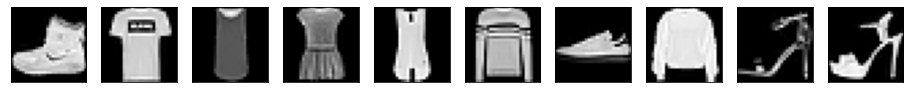

In [ ]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Preprocess data

In [ ]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255.

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


### Define channel & spatial attention module, autoencoder block

* channel attention
<img src="./imgaes/channel attention.png" width="480" height="480">

* spatial attention
<img src="./imgaes/spatial attention.png" width="480" height="480">


In [ ]:
def channel_attention(x, name, r=4):
    ch = x.shape[-1]
    ch_reduced = ch/r
    
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(x)

    excitation = tf.keras.layers.Dense(ch_reduced)(squeeze)
    excitation = tf.keras.layers.ReLU()(excitation)
    excitation = tf.keras.layers.Dense(ch, activation='sigmoid')(excitation)
    
    output = tf.keras.layers.Multiply()([x, excitation])

    return  output

def spatial_attention(x, name):
    
    conv = tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1, 1), padding='same', activation='sigmoid')(x)

    output = tf.keras.layers.Multiply()([x, conv])

    return  output

def autoencoder_block(x, filter, name):
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

### Define networks

In [ ]:
def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x, 'CA1')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x, 'CA2')
        
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = channel_attention(x, 'CA3')
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x, 'CA4')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x, 'CA5')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x, 'CA6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x, 'SA1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x, 'SA2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = spatial_attention(x, 'SA3')
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x, 'SA4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x, 'SA5')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x, 'SA6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

def autoencoder_parellel_add(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    sa = spatial_attention(x, 'SA1')
    ca = channel_attention(x, 'CH1')
    x = tf.keras.layers.Add()([ca, sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    sa = spatial_attention(x, 'SA2')
    ca = channel_attention(x, 'CH2')
    x = tf.keras.layers.Add()([ca, sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    sa = spatial_attention(x, 'SA3')
    ca = channel_attention(x, 'CH3')
    x = tf.keras.layers.Add()([ca, sa])
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    sa = spatial_attention(x, 'SA4')
    ca = channel_attention(x, 'CH4')
    x = tf.keras.layers.Add()([ca, sa])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    sa = spatial_attention(x, 'SA5')
    ca = channel_attention(x, 'CH5')
    x = tf.keras.layers.Add()([ca, sa])
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    sa = spatial_attention(x, 'SA6')
    ca = channel_attention(x, 'CH6')
    x = tf.keras.layers.Add()([ca, sa])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img 

def autoencoder_parellel_mul(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    sa = spatial_attention(x, 'SA1')
    ca = channel_attention(x, 'CH1')
    x = tf.keras.layers.Multiply()([ca, sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    sa = spatial_attention(x, 'SA2')
    ca = channel_attention(x, 'CH2')
    x = tf.keras.layers.Multiply()([ca, sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    sa = spatial_attention(x, 'SA3')
    ca = channel_attention(x, 'CH3')
    x = tf.keras.layers.Multiply()([ca, sa])
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    sa = spatial_attention(x, 'SA4')
    ca = channel_attention(x, 'CH4')
    x = tf.keras.layers.Multiply()([ca, sa])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    sa = spatial_attention(x, 'SA5')
    ca = channel_attention(x, 'CH5')
    x = tf.keras.layers.Multiply()([ca, sa])
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    sa = spatial_attention(x, 'SA6')
    ca = channel_attention(x, 'CH6')
    x = tf.keras.layers.Multiply()([ca, sa])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img  

def autoencoder_serial_ca(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x, 'CH1')
    x = spatial_attention(x, 'SA1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x, 'CH2')
    x = spatial_attention(x, 'SA2')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = channel_attention(x, 'CH3')
    x = spatial_attention(x, 'SA3')   
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x, 'CH4')
    x = spatial_attention(x, 'SA4')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x, 'CH5')
    x = spatial_attention(x, 'SA5')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x, 'CH6')
    x = spatial_attention(x, 'SA6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img        

def autoencoder_serial_sa(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x, 'SA1')
    x = channel_attention(x, 'CH1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x, 'SA2')
    x = channel_attention(x, 'CH2')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = spatial_attention(x, 'SA3')
    x = channel_attention(x, 'CH3')
    
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x, 'SA4')
    x = channel_attention(x, 'CH4')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x, 'SA5')
    x = channel_attention(x, 'CH5')
    
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x, 'SA6')
    x = channel_attention(x, 'CH6')
    
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img     

### Define Input & Outputs

### Build models

In [ ]:
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_parellel_add_data = autoencoder_parellel_add(input_data)
output_parellel_mul_data = autoencoder_parellel_mul(input_data)
output_serial_ca_data = autoencoder_serial_ca(input_data)
output_serial_sa_data = autoencoder_serial_sa(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial  = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_parellel_add  = tf.keras.Model(inputs=input_data, outputs=output_parellel_add_data)
model_parellel_mul  = tf.keras.Model(inputs=input_data, outputs=output_parellel_mul_data)
model_serial_ca  = tf.keras.Model(inputs=input_data, outputs=output_serial_ca_data)
model_serial_sa  = tf.keras.Model(inputs=input_data, outputs=output_serial_sa_data)

model.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128   

### Compile models

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_ca.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_sa.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

### Train models

In [ ]:
#Train Normal Model
print('Training Normal Model')
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))

#Train Channel Attention Model
print()
print('Training Channel Attention Model')
history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))

#Train Spatial Attention Model
print()
print('Training Spatial Attention Model')
history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))

#Train Parelle add  Model
print()
print('Training Parelle add  Model')
history_parellel_add = model_parellel_add.fit(x_train, x_train, 
                        batch_size=16, 
                        epochs=30,
                        shuffle=True,
                        validation_data=(x_test, x_test))

#Train Parellel Mul Model
print()
print('Training  Parellel Mul Model')
history_parellel_mul = model_parellel_mul.fit(x_train, x_train, 
                        batch_size=16, 
                        epochs=30,
                        shuffle=True,
                        validation_data=(x_test, x_test))

#Train Serial CA Model
print()
print('Training Serial CA Model')
history_serial_ca = model_serial_ca.fit(x_train, x_train, 
                        batch_size=16, 
                        epochs=30,
                        shuffle=True,
                        validation_data=(x_test, x_test))

#Train Serial SA Model
print()
print('Training Serial SA Model')
history_serial_sa = model_serial_sa.fit(x_train, x_train, 
                        batch_size=16, 
                        epochs=30,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Training Normal Model
Epoch 1/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/30
3750/3750 [===========

### Predict models

In [ ]:
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_parellel_add = model_parellel_add.predict(x_test)
recons_parellel_mul = model_parellel_mul.predict(x_test)
recons_serial_ca = model_serial_ca.predict(x_test)
recons_serial_sa = model_serial_sa.predict(x_test)

### Reshape ouputs

In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)
recons_parellel_add = recons_parellel_add.reshape(-1, 28, 28)
recons_parellel_mul = recons_parellel_mul.reshape(-1, 28, 28)
recons_serial_ca = recons_serial_ca.reshape(-1, 28, 28)
recons_serial_sa = recons_serial_sa.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

### Visualize outputs

* test image

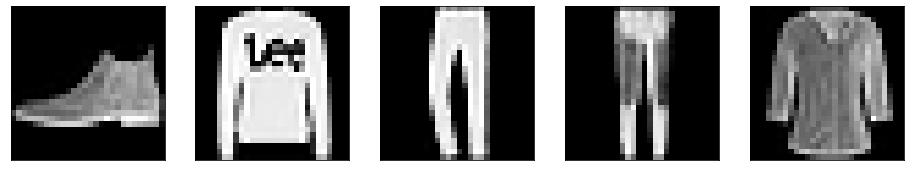

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* vanilla autoencoder's output

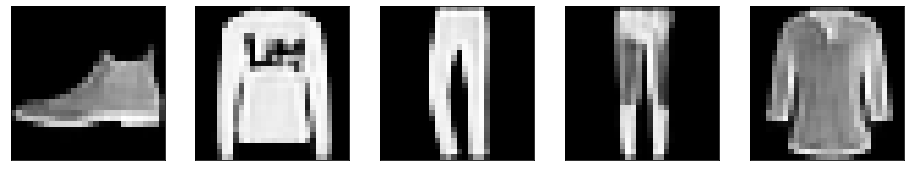

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* channel attention's output

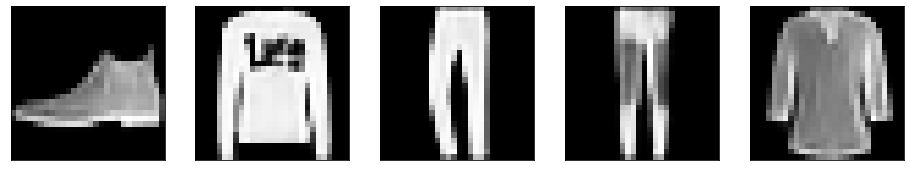

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* spatial attention's output

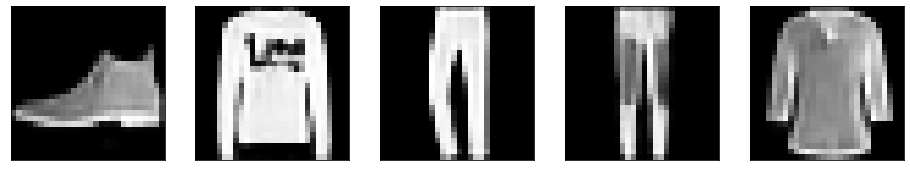

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* parellel add's output

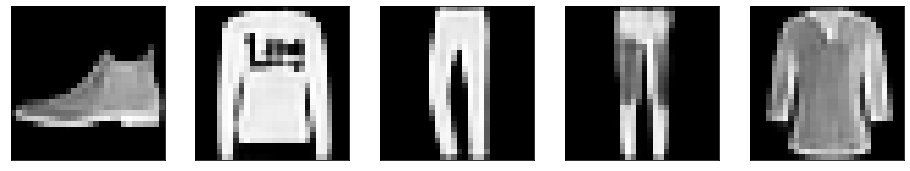

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* parellel add's output

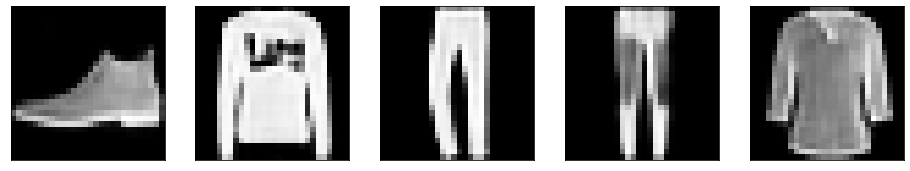

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* serial ca's output

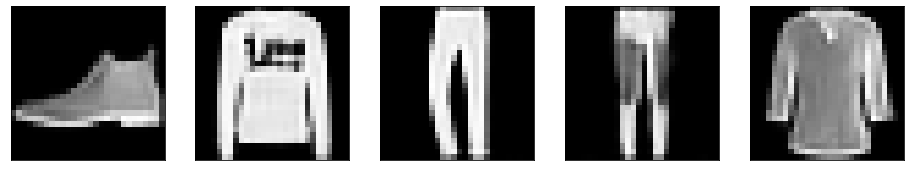

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_ca[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

* serial sa's output

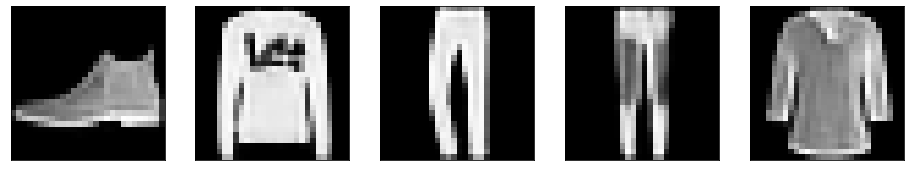

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_sa[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

### Plot train & validation loss

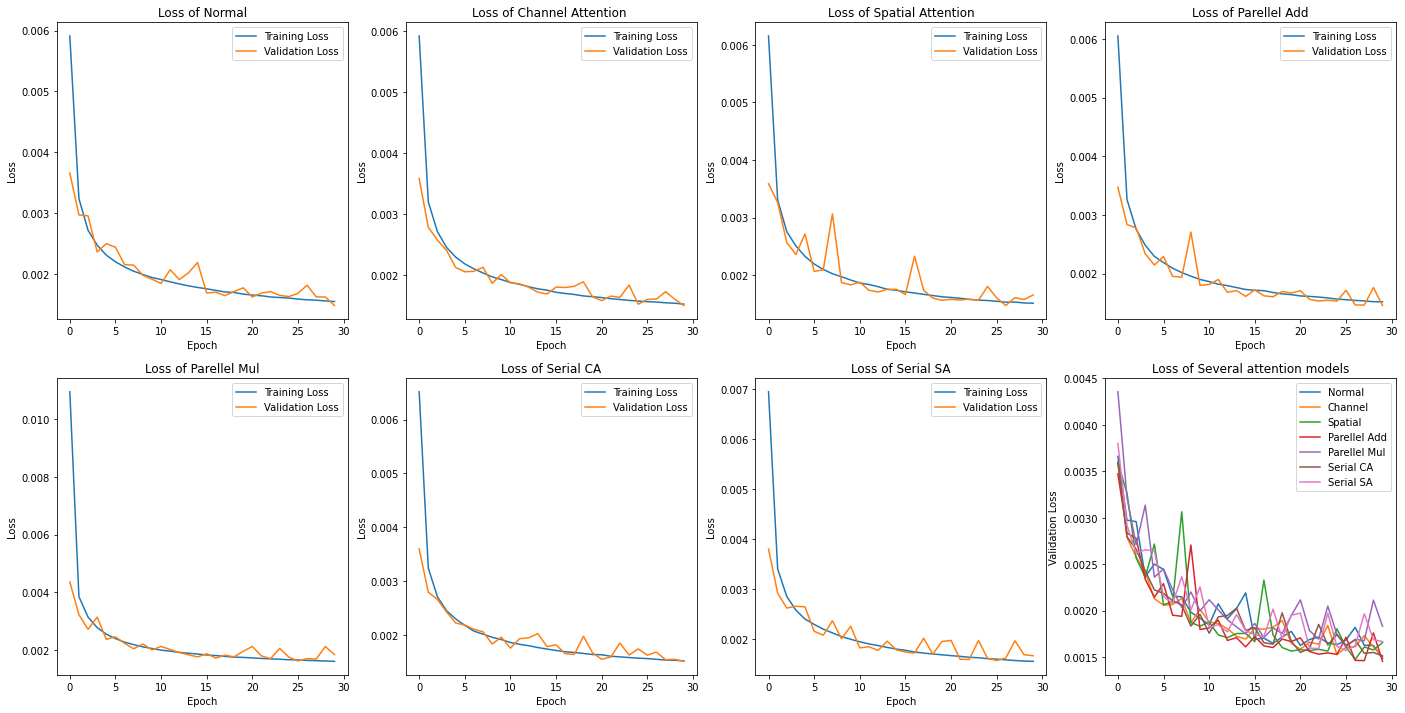

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history_parellel_add.history['loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history_parellel_mul.history['loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(history_serial_ca.history['loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(history_serial_sa.history['loss'])
plt.plot(history_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(history.history['val_loss'])
plt.plot(history_channel.history['val_loss'])
plt.plot(history_spatial.history['val_loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.plot(history_serial_sa.history['val_loss'])

plt.title('Loss of Several attention models')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()

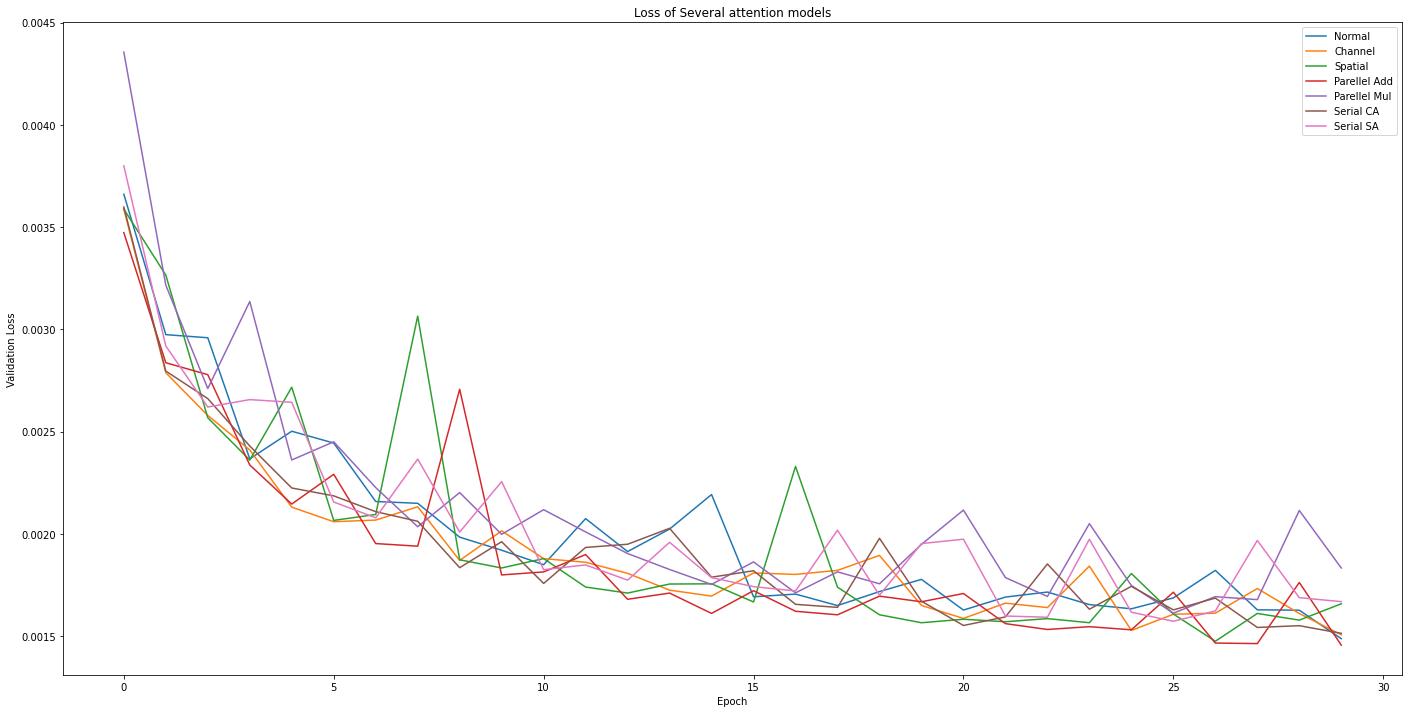

In [ ]:
plt.figure(figsize=(24,12))
plt.plot(history.history['val_loss'])
plt.plot(history_channel.history['val_loss'])
plt.plot(history_spatial.history['val_loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.plot(history_serial_sa.history['val_loss'])

plt.title('Loss of Several attention models')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()